In [266]:
import pandas as pd
import tensorflow as tf
import numpy as np
import keras
from random import sample, shuffle
from math import floor
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale

In [267]:
class Dense(tf.Module):  # Denesly connected leyer
    # Note: No need for `in_features`
    def _linear_act(x):
        return x

    def __init__(self, out_features, act_func=_linear_act, name=None):
        super().__init__(name=name)
        self.is_built = False
        self.out_features = out_features  # Number of outputs
        self.act_func = act_func  # Activation function

    def __call__(self, x):
        # Create variables on first call.
        if not self.is_built:
            self.w = tf.Variable(tf.random.normal(
                [x.shape[-1], self.out_features]),
                name='w')
            self.b = tf.Variable(tf.zeros([self.out_features]), name='b')
            self.is_built = True

        y = tf.matmul(x, self.w) + self.b
        return self.act_func(y)


class Model(tf.Module):
    def __init__(self, layers=[], name=None):
        super().__init__(name=name)
        self.layers = layers

    # Feed forward on call
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


def _loss(model, inputs, target_y):
    pred_y = model(inputs)
    return tf.reduce_mean(tf.square(target_y - pred_y))


def _grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = _loss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)


def _get_batches(X, Y, batch_size):
    n_data = len(X)
    # Shuffle data
    c = list(zip(X, Y))
    shuffle(c)
    X, Y = zip(*c)
    # Splitting into batches
    X, Y = np.array(X).astype('float32'), np.array(Y).astype('float32')
    x, y = [], []
    for i in range(0, n_data - batch_size, batch_size):
        x.append(X[i:i + batch_size])
        y.append(Y[i:i + batch_size])
    return x, y


def train(model,
          X,
          Y,
          epochs=10,
          batch_size=1,
          optimiser=tf.optimizers.Adam(0.01)):

    train_loss_results = []
    valid_loss_results = []
    test_loss_results = []

    for epoch in range(epochs):
        ##STATS##
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_loss_valid = tf.keras.metrics.Mean()
        epoch_loss_test = tf.keras.metrics.Mean()
        ##STATS##
        # Creating new batches for every epoch
        x, y = _get_batches(X, Y, batch_size)
        for i in range(0, len(x)):  # For all each batch
            loss_value, grads = _grad(model, x[i], y[i])
            ##STATS##
            epoch_loss_avg.update_state(loss_value)
            epoch_loss_valid.update_state(_loss(model, x_valid, y_valid))
            epoch_loss_test.update_state(_loss(model, x_test, y_test))
            ##STATS##
            optimiser.apply_gradients(zip(grads, model.trainable_variables))

        train_loss_results.append(epoch_loss_avg.result().numpy())
        valid_loss_results.append(epoch_loss_valid.result().numpy())
        test_loss_results.append(epoch_loss_test.result().numpy())
        if ((epoch + 1) % 50 == 0):
            print("Epoch: {}; Loss: {}".format(
                epoch + 1,
                epoch_loss_avg.result().numpy()))
    return (train_loss_results, valid_loss_results, test_loss_results)

In [268]:
P_TRAIN = 0.81  # Fraction of dataset
P_VALID = 0.085

arecibo_df = pd.read_csv('Arecibo_DF')
x_values = arecibo_df.drop(['MHI', 'Name'], axis=1).values.astype('float32')
x_values = scale(x_values)
y_values = arecibo_df['MHI'].values.astype('float32')
y_values = np.reshape(y_values, (-1, 1))

n_data = len(x_values)
n_train = floor(n_data*P_TRAIN)
n_valid = floor(n_data*P_VALID)

c = list(zip(x_values, y_values))
shuffle(c)
x_shuf, y_shuf = zip(*c)

x_train, y_train = x_shuf[0:n_train], y_shuf[0:n_train]
x_valid, y_valid = x_shuf[n_train:n_train +
                            n_valid], y_shuf[n_train:n_train + n_valid]
x_test, y_test = x_shuf[n_train + n_valid:n_data], y_shuf[n_train + n_valid:n_data]

print("Training set size: " + str(len(x_train)))
print("Test set size: " + str(len(x_test)))
print("Validtaion set size: " + str(len(x_valid)))

Training set size: 100
Test set size: 14
Validtaion set size: 10


C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [269]:
# adam_model = Model([Dense(8, tf.nn.sigmoid),
#               Dense(16, tf.nn.sigmoid),
#               Dense(16, tf.nn.sigmoid),
#              Dense(1)])
adam_model = Model([Dense(8, tf.nn.sigmoid),
                    Dense(16, tf.nn.sigmoid),
                    Dense(16, tf.nn.sigmoid),
                    Dense(16, tf.nn.sigmoid),
                    Dense(16, tf.nn.sigmoid),
                    Dense(1),])
adam_results = train(adam_model, x_train, y_train, epochs=1000,
                     batch_size=8, optimiser=tf.optimizers.Adam(0.01))

Epoch: 50; Loss: 0.045006368309259415
Epoch: 100; Loss: 0.011931906454265118
Epoch: 150; Loss: 0.010186840780079365
Epoch: 200; Loss: 0.007564023602753878
Epoch: 250; Loss: 0.006298759486526251
Epoch: 300; Loss: 0.005366969853639603
Epoch: 350; Loss: 0.002256882144138217
Epoch: 400; Loss: 0.0018644925439730287
Epoch: 450; Loss: 0.0033179905731230974
Epoch: 500; Loss: 0.0029286809731274843
Epoch: 550; Loss: 0.001332334359176457
Epoch: 600; Loss: 0.0016860375180840492
Epoch: 650; Loss: 0.003952807281166315
Epoch: 700; Loss: 0.0033783947583287954
Epoch: 750; Loss: 0.0017293734708800912
Epoch: 800; Loss: 0.0012774862116202712
Epoch: 850; Loss: 0.0015272684395313263
Epoch: 900; Loss: 0.0014049713499844074
Epoch: 950; Loss: 0.0007733483798801899
Epoch: 1000; Loss: 0.0018690865254029632


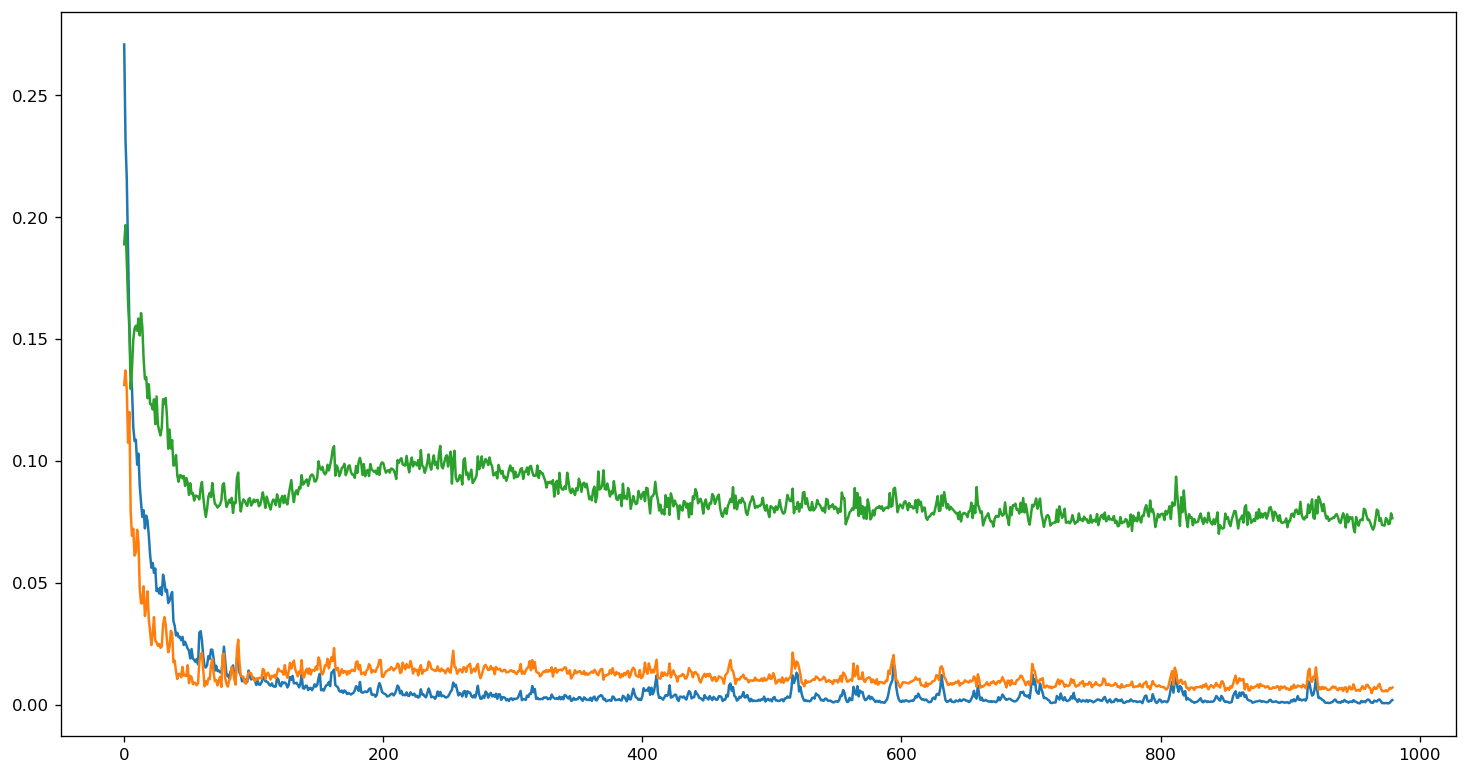

In [270]:
plt.figure(dpi=120, figsize=(15, 8))
plt.plot(adam_results[0][20:])
plt.plot(adam_results[1][20:])
plt.plot(adam_results[2][20:])

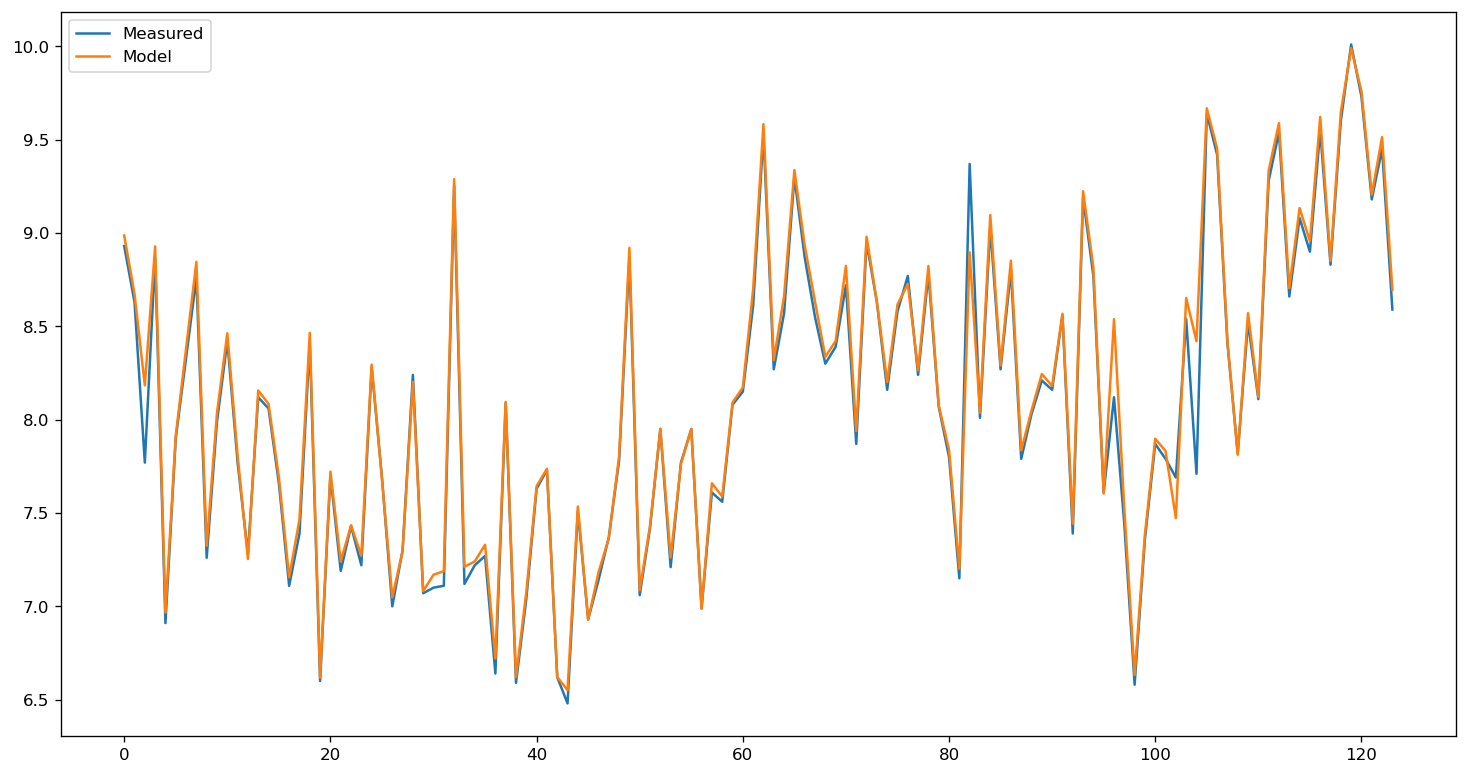

In [271]:
y_pred = adam_model(x_values)
y = y_values
plt.figure(dpi=120, figsize=(15, 8))
measured_l, = plt.plot(range(0, len(y)), y)
model_l, = plt.plot(range(0, len(y)), y_pred)
plt.legend([measured_l, model_l], ('Measured', 'Model'))
plt.show()

In [272]:
nancay_df = pd.read_csv('Nancay_DF')
nancay_df = nancay_df[~nancay_df['Name'].isin(arecibo_df['Name'])]

In [273]:
nancay_x = nancay_df.drop(['Name', 'MHI'], axis=1).values.astype('float32')
nancay_x = scale(nancay_x)

nancay_y = nancay_df['MHI'].values 
nancay_y = nancay_y

C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


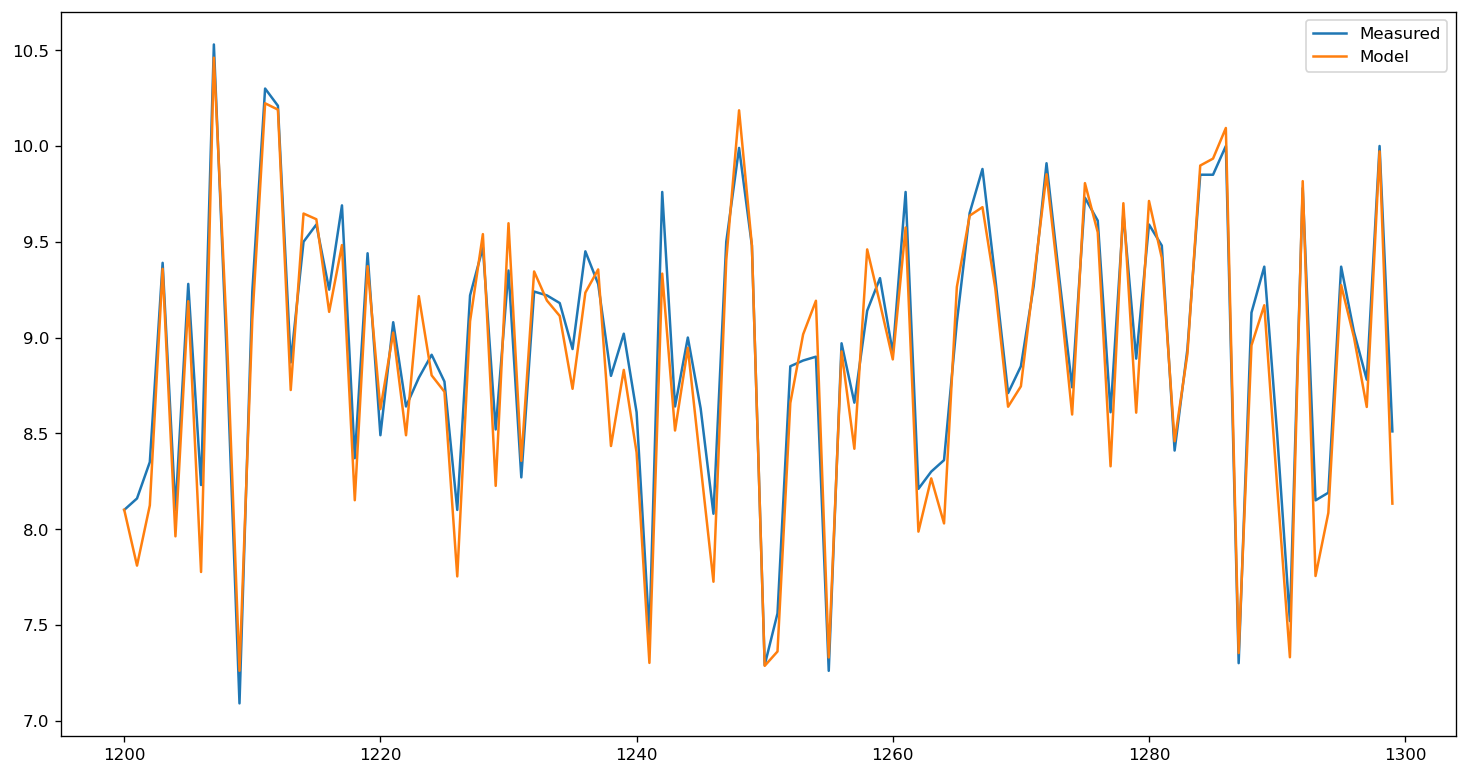

In [274]:
strt = 1200
ran = 100
nancay_x_sub = nancay_x[strt:ran+strt]
nancay_y_sub = nancay_y[strt:ran + strt]
nancay_pred_y = adam_model(nancay_x_sub)

plt.figure(dpi=120, figsize=(15, 8))
measured_l, = plt.plot(range(strt, ran + strt), nancay_y_sub)
model_l, = plt.plot(range(strt, ran + strt), nancay_pred_y + (np.mean(nancay_y) - arecibo_df['MHI'].mean()))
plt.legend([measured_l, model_l], ('Measured', 'Model'))
plt.show()

In [275]:
nancay_pred = adam_model(nancay_x)
print("Nancay prediction mean: " + str(np.mean(nancay_pred)))
print("Nancay observation mean: " + str(np.mean(nancay_y)))

print("Arecibo prediction mean: " + str(np.mean(adam_model(x_values))))
print("Arecibo observation mean: " + str(arecibo_df['MHI'].mean()))

Nancay prediction mean: 8.012001
Nancay observation mean: 8.925523223279239
Arecibo prediction mean: 8.116308
Arecibo observation mean: 8.074596774193548


In [276]:
print(arecibo_df.mean(axis = 0))
arecibo_means = arecibo_df.mean(axis =0)
#arecibo_means = scale(arecibo_means)
ar_mhi_mean = arecibo_means[10]
def calculate_distance(mean, value):
    return np.sum(value-mean)

Vopt    2808.370968
g-z        0.607258
gMAG     -15.931290
M*         8.039701
sSFR      -9.783953
rms        0.561290
VHI     2810.572581
W50       96.379032
FHI        1.041371
S/N       28.317823
MHI        8.074597
dtype: float64


In [277]:
nancay_values = nancay_df.drop('Name', axis = 1).values
#nancay_values = scale(nancay_values)
sample_size = 100
max_distance = 2
acc_dev= 0.2



best_value_index = 0 
last_dist = 0
sample = []
to_ignore = []
for i in range(sample_size-1):
    smallest_suit_sep = 999
    for j in range(len(nancay_values)):
        if j in to_ignore:
            continue
        value = nancay_values[j]
        distance = calculate_distance(ar_mhi_mean, value[10])
        if(abs(distance) > max_distance):
            continue
        sep_from_needed_value = distance + last_dist
        if(abs(sep_from_needed_value) < acc_dev and
           sep_from_needed_value < smallest_suit_sep):       
            smallest_suit_sep = sep_from_needed_value
            best_value_index = j
            break
    sample.append(nancay_df.values[best_value_index])
    last_dist = calculate_distance(ar_mhi_mean, nancay_values[best_value_index][10])
    to_ignore.append(best_value_index)
sample = np.array(sample)
sample_df = pd.DataFrame(sample, columns = nancay_df.columns)

In [278]:
#print(sample_df)

In [279]:
sample_x = sample_df.drop(['Name', 'MHI'], axis=1).values.astype('float32')
sample_x = scale(sample_x)

sample_y = sample_df['MHI'].values 
print(np.mean(sample_y))

print("Arecibo observation mean: " + str(arecibo_df['MHI'].mean()))

8.116363636363639
Arecibo observation mean: 8.074596774193548


C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:194: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\Gordei\anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\_data.py:211: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


8.139431


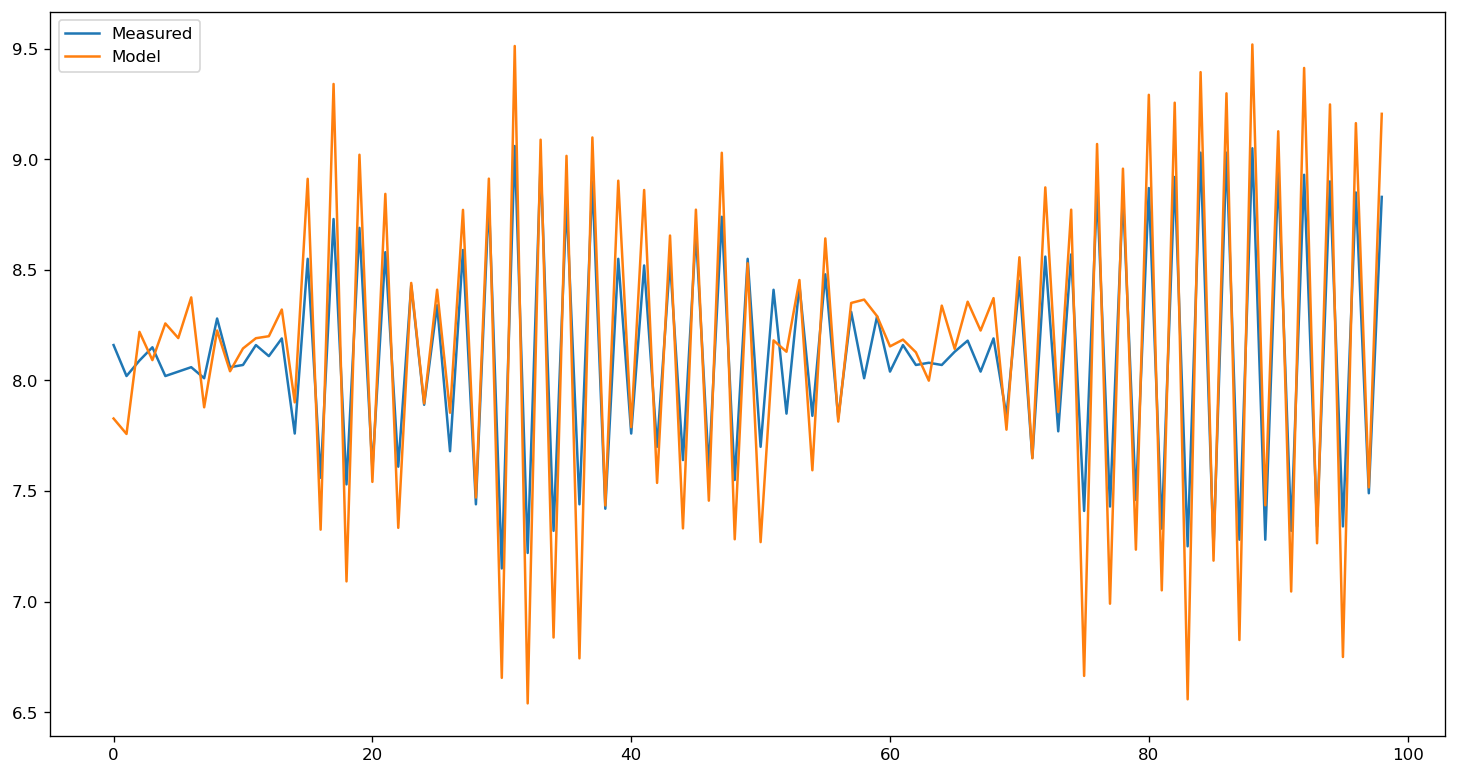

In [317]:
sample_pred_y = adam_model(sample_x)
print(np.mean(sample_pred_y))
plt.figure(dpi=120, figsize=(15, 8))
measured_l, = plt.plot(range(0, len(sample_pred_y)), sample_y)
model_l, = plt.plot(range(0, len(sample_pred_y)), sample_pred_y)
plt.legend([measured_l, model_l], ('Measured', 'Model'))
plt.show()

In [316]:
sample_df_withpred = sample_df
print(np.squeeze(sample_pred_y))
sample_df_withpred['PRED MHI'] = pd.Series(np.squeeze(sample_pred_y))
sample_df_withpred.to_csv('Nancay_subset.txt', index = False)

[7.8278894 7.758093  8.219567  8.091936  8.257798  8.1916    8.375564
 7.8786635 8.225786  8.041582  8.144633  8.191009  8.200071  8.320779
 7.9009356 8.911766  7.325299  9.340636  7.09142   9.020587  7.541349
 8.843635  7.33356   8.440906  7.896225  8.410377  7.8540397 8.771345
 7.470757  8.912521  6.655252  9.512309  6.539791  9.088603  6.837651
 9.015548  6.743476  9.0987625 7.4349136 8.903258  7.7890153 8.861236
 7.536748  8.655224  7.3311253 8.772264  7.4564238 9.029495  7.2818823
 8.529725  7.2690244 8.181114  8.129821  8.45422   7.5939083 8.642255
 7.814081  8.350409  8.365588  8.290742  8.15397   8.184708  8.127351
 7.998978  8.338268  8.142729  8.356072  8.225728  8.372174  7.777458
 8.556955  7.647964  8.8729    7.8575506 8.7721815 6.6640387 9.069181
 6.9905295 8.957635  7.234971  9.291577  7.050913  9.25592   6.558296
 9.394174  7.185237  9.29831   6.826403  9.519179  7.4354663 9.126674
 7.045708  9.413081  7.2638397 9.24805   6.7496104 9.163484  7.516657
 9.205573 ]
